In [1]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def props_mysql():
    db = pymysql.connect(host='127.0.0.1',
                         user='root', passwd='root',
                         db='global')

    return db

In [3]:
def make_query(db, query):
    cur = db.cursor()
    cur.execute(query)
    return cur


In [4]:
query = "select * from Site"
df = pd.read_sql(query, con=props_mysql())

In [5]:
keep_site_fields = ["IDSite", "Site_Country", "Site_City_State_Region",
                    "Site_Soil_Classification_Name","Site_Soil_Sand_Percentage", "Site_Soil_Silt_Percentage",
                   "Site_Soil_pH", "Site_Soil_Organic_Matter_Percentage", "Site_Soil_N_Percentage",
                   "Site_Soil_C_Percentage", "Site_Precipitation_mm", "Site_Temperature_Celsius"] 

In [6]:
#Keeping only some interesting fields
sites = df[keep_site_fields]
#removing NA
sites = sites.replace('NA',np.NaN)

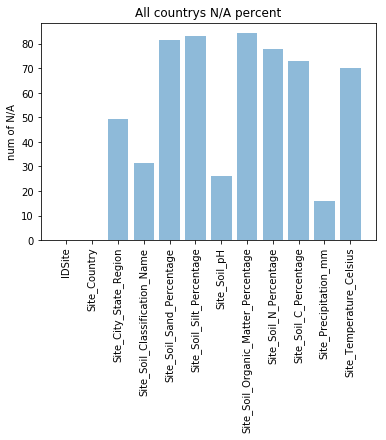

In [7]:
def make_nan_chart(df, title="All countrys N/A percent"):
    nans = df.isnull().sum()
    x_axis = list(nans.index)
    x_pos = np.arange(len(x_axis))
    y_axis = list(nans.values)
    y_percent = map(lambda y: (y*1.0/int(df.shape[0]))*100, y_axis)
    plt.bar(list(x_pos), list(y_percent), align='center', alpha=0.5)
    plt.xticks(x_pos, x_axis,  rotation='vertical')
    plt.ylabel('num of N/A') 
    plt.title(title)
    plt.show()

make_nan_chart(sites)

In [8]:
#Quero escolher uma regiao que tenha dados os suficientes para serem trabalhados nas outras tabelas
#checando numero de eventos por regiao
query = str("select count(*) as qtd_samples, Site_Country from Site group by Site_Country")
df = pd.read_sql(query, con=props_mysql())
df = df.loc[df['qtd_samples'] >= 10].sort_values(['qtd_samples'], ascending=[0])
lista_paises = list(df['Site_Country'].values)  
    

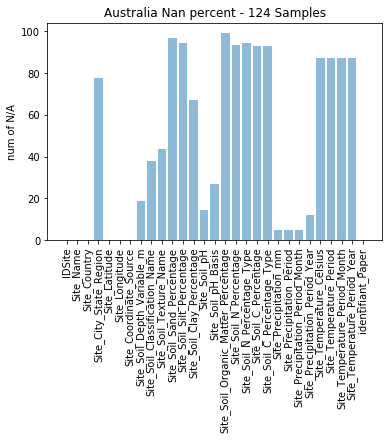

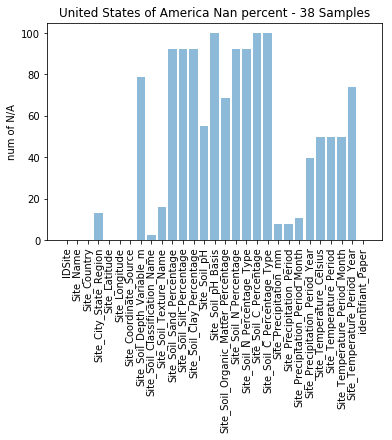

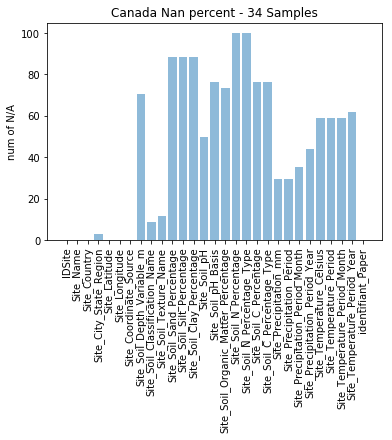

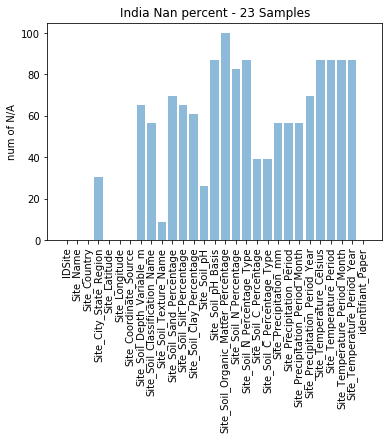

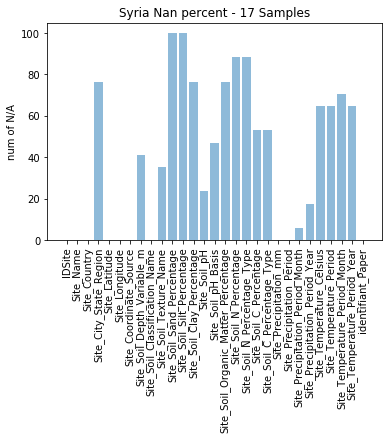

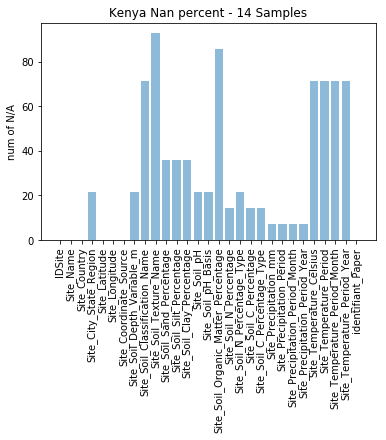

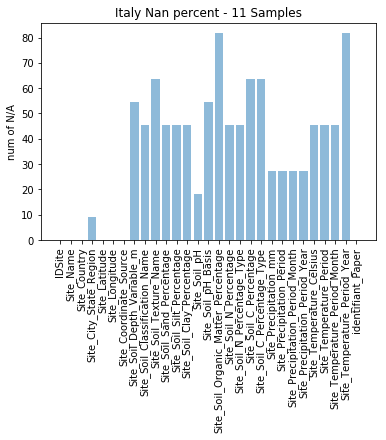

In [9]:
#checando nulos por regiao
for pais in lista_paises:
    query = str("select * from Site where Site_Country='{}'".format(pais))
    df = pd.read_sql(query, con=props_mysql())
    #Keeping only some interesting fields
    #removing NA
    country_data = df.replace('NA',np.NaN)
    make_nan_chart(country_data, title= str(pais)+" Nan percent - "+ str(country_data.shape[0]) + " Samples")
    
    

Working in Australia...
Temos 96 sites com todos os dados que precisamos no momento no pais Australia
(1282, 143)
Australia tem 43 features que podemos aproveitar

Working in United States of America...
Temos 4 sites com todos os dados que precisamos no momento no pais United States of America
(442, 143)
United States of America tem 47 features que podemos aproveitar

Working in Canada...
Temos 10 sites com todos os dados que precisamos no momento no pais Canada
(272, 143)
Canada tem 41 features que podemos aproveitar

Working in India...
Temos 3 sites com todos os dados que precisamos no momento no pais India
(92, 143)
India tem 48 features que podemos aproveitar

Working in Syria...
Temos 9 sites com todos os dados que precisamos no momento no pais Syria
(80, 143)
Syria tem 51 features que podemos aproveitar

Working in Kenya...
Temos 11 sites com todos os dados que precisamos no momento no pais Kenya
(162, 143)
Kenya tem 45 features que podemos aproveitar

Working in Italy...
Temos 

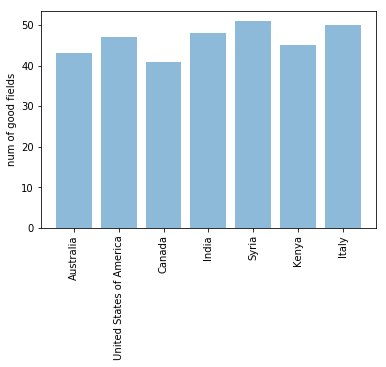

In [36]:
#Testando com todos os paises
list_dicts_fields_uteis = []
df_all_countrys = pd.DataFrame()
for pais in lista_paises:
    dict_fields_uteis = {}
    dict_fields_uteis['pais']=pais
    #Para cada pais checo os dados essencais da tabela site
    print("Working in {}...".format(pais))
    fields_uteis = ['IDSite', 'Site_Soil_Depth_Variable_m', 'Site_Soil_pH', 'Site_Precipitation_mm']
    query = str("select IDSite, Site_Soil_Depth_Variable_m, Site_Soil_pH, Site_Precipitation_mm from Site where Site_Country= '{}'").format(pais)
    df = pd.read_sql(query, con=props_mysql())
    df_pais = df.replace('NA',np.NaN)
    df_pais = df_pais.dropna().reset_index()
    print("Temos {} sites com todos os dados que precisamos no momento no pais {}".format(len(df_pais['IDSite'].unique()), pais))
    lista_IDSites = list(df_pais['IDSite'].unique())
    df_all = pd.DataFrame()
    for id in lista_IDSites:
        #Com a lista de ids prontos para uso faco o join com as outras tabelas do banco
        query = str("select * from Crop as crop"
                   " join Crop_Sequence_Trt as crop_s"
                   " on crop.IDRotation_CropSystem = crop_s.IDRotation"
                   " join Site as site"
                   " on crop_s.IDSite_Site = site.IDSite"
                   " where site.IDSite={}").format(id)
        df = pd.read_sql(query, con=props_mysql())
        #Concateno o resultado de cada query em um unico dataframe
        df_all = pd.concat([df_all, df])
        df_all = df_all.replace('NA',np.NaN)
        

    print(df_all.shape)
    df_all_countrys = pd.concat([df_all_countrys, df_all])
    #depois que o dataframe final esta completo
    #calculo os nans do dataframe final para cada iteracao de pais
    nans = df_all.isnull().sum()
    x_axis = list(nans.index)
    y_axis = list(nans.values)
    y_percent = list(map(lambda y: (y*1.0/int(df_all.shape[0]))*100, y_axis))
    df_percents_all = pd.DataFrame()
    df_percents_all['label'] = x_axis
    df_percents_all['percents'] = y_percent
    #quero saber apenas os campos que tem menos que 25% de nans
    percents = df_percents_all.loc[df_percents_all['percents'] < 25]
    percents = percents.sort_values(['percents'])
    dict_fields_uteis['qtd_fields_uteis'] = percents.shape[0]
    dict_fields_uteis['labels_fields_uteis'] = percents['label'].values
    list_dicts_fields_uteis.append(dict_fields_uteis)
    print('=======================================================================')
    print('{} tem {} features que podemos aproveitar'.format(pais, percents.shape[0]))
    print('=======================================================================')
    print('')

#plotting nan percent per contry    
x_axis = [d['pais'] for d in list_dicts_fields_uteis]
x_pos = np.arange(len(x_axis))
y_axis = [d['qtd_fields_uteis'] for d in list_dicts_fields_uteis]
plt.bar(list(x_pos), list(y_axis), align='center', alpha=0.5)
plt.xticks(x_pos, x_axis,  rotation='vertical')
plt.ylabel('num of good fields') 
plt.show()

In [37]:
#Lista de features com dados suficientes (por pais)
list_dicts_fields_uteis

[{'labels_fields_uteis': array(['IDCrop', 'Crop_Sequence_Trt_Species_Order',
         'Crop_Sequence_Trt_Species_Number',
         'Crop_Sequence_Trt_Species_Legume_Harvested',
         'Crop_Sequence_Trt_Growing_Season_Number', 'IDSite_Site', 'IDSite',
         'Site_Name', 'Crop_Sequence_Trt_Name', 'Site_Country',
         'Site_Longitude', 'Site_Coordinate_Source',
         'Site_Soil_Depth_Variable_m', 'Site_Soil_pH',
         'Site_Precipitation_mm', 'Site_Precipitation_Period',
         'Site_Precipitation_Period_Month', 'Site_Latitude',
         'IDRotation_CropSystem', 'IDRotation', 'Crop_Date_Seeding',
         'Crop_Sequence_Treatment_Name', 'Crop_Site_Growing_Season_ID',
         'Crop_Growing_Season_Year_First', 'Crop_Growing_Season_Year_Last',
         'Crop_Growing_Season_Number', 'Crop_Species_Scientific_Name',
         'Crop_Species_Common_Name', 'Crop_Species_Legume',
         'Crop_Date_Harvest', 'identifiant_Paper',
         'Crop_Multiple_Following_For_Same_Precedin

In [40]:
query = str("select * from Crop as crop"
                   " join Crop_Sequence_Trt as crop_s"
                   " on crop.IDRotation_CropSystem = crop_s.IDRotation"
                   " join Site as site"
                   " on crop_s.IDSite_Site = site.IDSite"
                   " where site.Site_Country='United States of America'")
df = pd.read_sql(query, con=props_mysql())

In [43]:
df = df[list_dicts_fields_uteis[1]['labels_fields_uteis']] #([1] is united states)

In [53]:
df

,IDCrop,Crop_Sequence_Trt_Species_Legume_Harvested,Crop_Sequence_Trt_Cultivar_Name,Crop_Sequence_Trt_Growing_Season_Number,IDSite_Site,IDSite,Site_Name,Site_Country,Site_Latitude,Site_Longitude,...,Crop_Replicate_Number,Crop_Yield_Grain,Crop_Yield_Grain_Unit,identifiant_Paper,Crop_Date_From_Seeding_To_Harvest_Day_Number,Site_Precipitation_Period_Year,Site_City_State_Region,Site_Temperature_Period_Month,Site_Temperature_Celsius,Site_Temperature_Period
0,1090,1,AC Greenfix,1.0,74,74,Akron,United States of America,40.15,-103.15,...,4,0.99,t.ha-1,34,61,NA,NA,NA,NA,NA
1,1091,1,AC Greenfix,1.0,74,74,Akron,United States of America,40.15,-103.15,...,4,0.74,t.ha-1,34,61,NA,NA,NA,NA,NA
2,1092,1,AC Greenfix,1.0,74,74,Akron,United States of America,40.15,-103.15,...,4,1.25,t.ha-1,34,61,NA,NA,NA,NA,NA
3,1087,1,AC Greenfix,1.0,74,74,Akron,United States of America,40.15,-103.15,...,4,1.72,t.ha-1,34,61,NA,NA,NA,NA,NA
4,1088,1,AC Greenfix,1.0,74,74,Akron,United States of America,40.15,-103.15,...,4,1.99,t.ha-1,34,61,NA,NA,NA,NA,NA
5,1089,1,AC Greenfix,1.0,74,74,Akron,United States of America,40.15,-103.15,...,4,2.08,t.ha-1,34,61,NA,NA,NA,NA,NA
6,1096,1,DS Admiral,1.0,74,74,Akron,United States of America,40.15,-103.15,...,4,1.05,t.ha-1,34,61,NA,NA,NA,NA,NA
7,1097,1,DS Admiral,1.0,74,74,Akron,United States of America,40.15,-103.15,...,4,0.72,t.ha-1,34,61,NA,NA,NA,NA,NA
8,1098,1,DS Admiral,1.0,74,74,Akron,United States of America,40.15,-103.15,...,4,1.28,t.ha-1,34,61,NA,NA,NA,NA,NA
9,1093,1,DS Admiral,1.0,74,74,Akron,United States of America,40.15,-103.15,...,4,1.90,t.ha-1,34,61,NA,NA,NA,NA,NA
